<a href="https://colab.research.google.com/github/dfu2020/ATMS-597-SP-2020-Project-3-Group-H/blob/master/Project3_GroupH_2_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

Task: Create code using python xarray to organize and reduce climate data. The goal of this analysis will be to detect global atmospheric circulation patterns (or teleconnections) associated with extreme daily precipitation in a certain part of the globe. You will

(1) Aggregate daily rainfall data from the Global Precipitaiton Climatology Project 1 degree daily precipitation data over the period **1996 - 2019** into a single file from daily files, available here: [https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/ ].

(2) Determine the 95% values of daily precipitation during a selected particular 3-month period (given in the table below by group) over the grid box closest to the city you are examining. Plot a cumulative distribution function of all values daily precipitation values and illustrate the 95% value of daily precipitation in millimeters.

(3) Using output from the NCEP Reanalysis [https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477(1996)077%3C0437%3ATNYRP%3E2.0.CO%3B2](Kalnay et al. 1996), compute the **global mean fields** and **seasonal anomaly fields** for days meeting and exceeding the threshold of precipitation calculated in the previous step (using the 1981-2010 as a base period for anomalies) of

* **250 hPa wind vectors and wind speed,**
* 500 hPa winds and geopotential height,
* 850 hPa temperature, specific humidity, and winds,
* **skin temperature, and surface winds,** and
* **total atmospheric column water vapor.**

(4) Create maps showing **the mean fields for the extreme precipitation day composites**, **long term mean composites for the selected months**, and **the anomaly fields for each variable**. Use contours and vectors when appropriate.

NCEP reanalysis data is available from the NOAA Physical Sciences Division THREDDS server here: [https://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/catalog.html]. xarray can access these files directly. For example, to get the long term mean for u-wind by month, you can access

`data = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.ltm.nc',engine='netcdf4')`

Aggregations of the 6-hourly data are available like this:

`data = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Aggregations/ncep.reanalysis/pressure/uwnd.nc', engine='netcdf4')`

## Data retrieval and processing

### module import

In [1]:
%pylab inline
!pip install netcdf4
!pip install pydap # to read remote netcdf files
!pip install wget
import xarray as xr
import pandas as pd
from datetime import datetime
import numpy as np
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import re
import wget

Populating the interactive namespace from numpy and matplotlib
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 317kB 38.4MB/s 
     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 122kB 41.7MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=6bf38fcbae608f3745ebcd1bd930800080570471906549c5d6ec63c1dbc57caf
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### Download GPCP data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Project_3_gpcp/

/content/drive/My Drive/Project_3_gpcp


In [0]:
years = np.arange(1996,2020)
url_home = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
# Get the file names from the website by looping through each year
gpcp_file_name = []
datasets = []
for year in years:
    gpcp_url=url_home +str(year)+'/'
    response = requests.get(gpcp_url)

    soup = BeautifulSoup(response.text, 'html.parser')
    gpcp_file_list = soup.find_all('a', href=re.compile("\.nc$"))
    #print(len(gpcp_file_list))
    print(year)
    for s in gpcp_file_list:
        filename=s.contents[0]
        file_url = (gpcp_url+filename)
        #print(file_url)
        wget.download(file_url)
        nc = xr.open_dataset(filename)
        precip = xr.DataArray(nc['precip'],dims=['time','latitude','longitude']) # load the precip data into a data array 
        datasets.append(precip) #append the datasets list with the precip data array
        !rm "{filename}"
combined = xr.concat(datasets, dim='time')

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [0]:
combined_dataset = combined.to_dataset(name='precip')

In [0]:
mdata=combined_dataset.sel(time=~combined_dataset.indexes['time'].duplicated())

In [0]:
mdata.to_netcdf('combined_1996_2019_precip.nc') #save the xarray dataset to a single netcdf file

### Getting the 95 percentile of daily precipitation for Melbourne, Australia.

In [0]:
mdata = xr.open_dataset('combined_1996_2019_precip.nc')
mdata_season=mdata.sel(time=(mdata['time.season'] == 'DJF'))

In [0]:
mdata_melbourne = mdata_season.sel(longitude=144.9631-1,latitude=-37.8136,method='nearest')

In [0]:
melbourne_precip=mdata_melbourne.where(mdata_melbourne>-9999.0, drop=True)

In [0]:
melbourne_results=melbourne_precip.precip.values

In [9]:
np.percentile(melbourne_results,95)

9.318601274490355

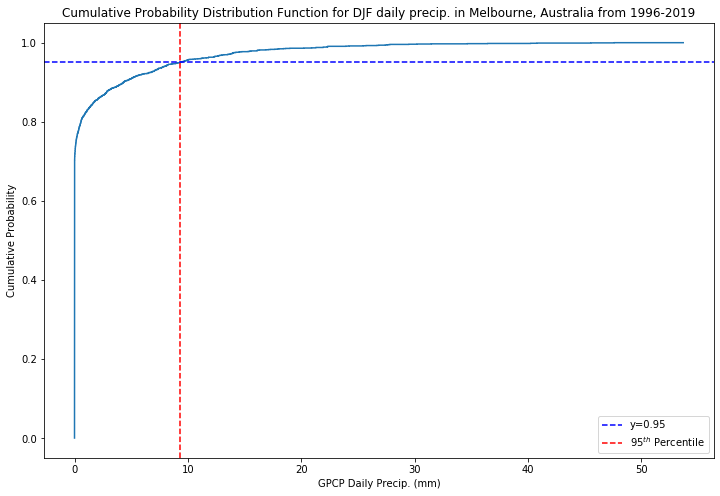

In [10]:
n = np.arange(1,len(melbourne_results)+1) / np.float(len(melbourne_results))
Xs = np.sort(melbourne_results)
fig, ax = plt.subplots(figsize=(12,8))
ax.step(Xs,n) 
plt.axhline(0.95,c='b',ls='--',label='y=0.95')
plt.axvline(np.percentile(melbourne_results,95),c='r',ls='--',label='$95^{th}$ Percentile')
plt.xlabel('GPCP Daily Precip. (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Distribution Function for DJF daily precip. in Melbourne, Australia from 1996-2019')
plt.legend()
plt.show()

In [0]:
melbourne_95 = mdata_melbourne.where(mdata_melbourne.precip >= np.percentile(melbourne_results,95),drop=True)

In [12]:
melbourne_95

<xarray.Dataset>
Dimensions:    (time: 104)
Coordinates:
    latitude   float32 -38.0
    longitude  float32 144.0
  * time       (time) datetime64[ns] 1997-01-27 1997-02-06 ... 2019-02-06
Data variables:
    precip     (time) float32 40.795677 9.493706 ... 24.217918 21.276585

In [0]:
melbourne_95.to_netcdf('melbourne_95.nc',encoding={'precip': {'_FillValue': -9999.0}})

### Global long term mean data

In [0]:
ltm_baseurl = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived'
ltm_item = {
    'uwnd_250': ['/pressure/uwnd.mon.1981-2010.ltm.nc', True, 250,'uwnd'], # True indicates that a level should be selected
    'vwnd_250': ['/pressure/vwnd.mon.1981-2010.ltm.nc', True, 250,'vwnd'],
    'skt': ['/surface_gauss/skt.sfc.mon.1981-2010.ltm.nc', False, 0, 'skt'],
    'uwnd_sfc': ['/surface/uwnd.sig995.mon.1981-2010.ltm.nc', False, 0, 'uwnd'],
    'vwnd_sfc': ['/surface/vwnd.sig995.mon.1981-2010.ltm.nc', False, 0, 'vwnd'],
    'pr_wtr': ['/surface/pr_wtr.eatm.mon.1981-2010.ltm.nc', False, 0, 'pr_wtr'],
    'wspd_250': ['/pressure/wspd.mon.1981-2010.ltm.nc', True, 250, 'wspd'],
    }

ltm_data = {}
for key in ltm_item.keys():
    if ltm_item[key][1] == False:
        d = xr.open_dataset(ltm_baseurl + ltm_item[key][0], engine='netcdf4')
    elif ltm_item[key][1] == True:
        d = xr.open_dataset(ltm_baseurl + ltm_item[key][0], engine='netcdf4').sel(level=ltm_item[key][2])
    data = d.sel(time=d.time.dt.season=='DJF')
    data_mean = data[ltm_item[key][3]].mean(dim='time')
    ltm_data.update( {key : data_mean} )

ltm_data

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time ax

{'pr_wtr': <xarray.DataArray 'pr_wtr' (lat: 73, lon: 144)>
 array([[ 2.2243922 ,  2.2243922 ,  2.2243922 , ...,  2.2243922 ,
          2.2243922 ,  2.2243922 ],
        [ 1.8074471 ,  1.7992644 ,  1.7932905 , ...,  1.837708  ,
          1.8268242 ,  1.8167206 ],
        [ 2.2656069 ,  2.323239  ,  2.381238  , ...,  2.111063  ,
          2.1579583 ,  2.2101562 ],
        ...,
        [ 0.35422215,  0.5226148 ,  0.67996675, ..., -0.1455404 ,
          0.0130877 ,  0.18235047],
        [ 0.414454  ,  0.44262624,  0.47272268, ...,  0.34229788,
          0.36278233,  0.38792774],
        [ 0.56360286,  0.56360286,  0.56360286, ...,  0.56360286,
          0.56360286,  0.56360286]], dtype=float32)
 Coordinates:
   * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0,
 'skt': <xarray.DataArray 'skt' (lat: 94, lon: 192)>
 array([[-32.721664, -32.74824 , -32.784206, ..., -32.616726, -32.651386,


In [0]:
# note that skt ltm data are in degC while daily data are in degK; 
# for the ease of the anomaly calculation we will update the numbers in 'skt'
# DataArray so they also have degK as units:
skt_mean_K = ltm_data['skt'] + 273.15
ltm_data.update(skt = skt_mean_K) 
ltm_data

{'pr_wtr': <xarray.DataArray 'pr_wtr' (lat: 73, lon: 144)>
 array([[ 2.2243922 ,  2.2243922 ,  2.2243922 , ...,  2.2243922 ,
          2.2243922 ,  2.2243922 ],
        [ 1.8074471 ,  1.7992644 ,  1.7932905 , ...,  1.837708  ,
          1.8268242 ,  1.8167206 ],
        [ 2.2656069 ,  2.323239  ,  2.381238  , ...,  2.111063  ,
          2.1579583 ,  2.2101562 ],
        ...,
        [ 0.35422215,  0.5226148 ,  0.67996675, ..., -0.1455404 ,
          0.0130877 ,  0.18235047],
        [ 0.414454  ,  0.44262624,  0.47272268, ...,  0.34229788,
          0.36278233,  0.38792774],
        [ 0.56360286,  0.56360286,  0.56360286, ...,  0.56360286,
          0.56360286,  0.56360286]], dtype=float32)
 Coordinates:
   * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0,
 'skt': <xarray.DataArray 'skt' (lat: 94, lon: 192)>
 array([[240.42833, 240.40175, 240.36578, ..., 240.53326, 240.49861,
     

### extreme precip days data

In [0]:
!ls

melbourne_95_update.nc	sample_data


In [0]:
dates = xr.open_dataset('melbourne_95_update.nc', engine = 'netcdf4')
dates['time']

<xarray.DataArray 'time' (time: 2)>
array(['1997-01-27T00:00:00.000000000', '1997-02-06T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    latitude   float32 ...
    longitude  float32 ...
  * time       (time) datetime64[ns] 1997-01-27 1997-02-06
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    bounds:         time_bounds

In [0]:
# since the first xprecip date is in 1997, so we start from 1997
years = pd.date_range(start='1997-01-01', end='2019-12-01', freq='AS') # 30 years

xprecip_baseurl = 'https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.dailyavgs'
# a dictionary of: 
# 'varname' = [url, whether it has levels, what level to use, varname in DataSet]
xprecip_item = { 
    'uwnd_250': ['/pressure/uwnd.', True, 250, 'uwnd'], 
    'vwnd_250': ['/pressure/vwnd.', True, 250, 'vwnd'],
    'skt': ['/surface_gauss/skt.sfc.gauss.', False, 0, 'skt'],
    'uwnd_sfc': ['/surface/uwnd.sig995.', False, 0, 'uwnd'],
    'vwnd_sfc': ['/surface/vwnd.sig995.', False, 0, 'vwnd'],
    'pr_wtr': ['/surface/pr_wtr.eatm.', False, 0, 'pr_wtr']
    #'wspd_250' is calculated later
    }

xprecip_data = {}
for key in xprecip_item.keys():
    datasets = []
    lv = int(xprecip_item[key][2])
    for iyr in years.year:
        url = xprecip_baseurl + xprecip_item[key][0] + str(iyr) + '.nc'
        dates_iyr = dates.sel(time = dates['time'].dt.year == iyr)['time']
        # if xprecip_item[key][1] == False:
        #     d = xr.open_dataset(url, engine = 'netcdf4').sel(time = dates_iyr) 
        # elif xprecip_item[key][1] == True:
        #     d = xr.open_dataset(url, engine = 'netcdf4').sel(time = dates_iyr)
        d = xr.open_dataset(url, engine = 'netcdf4').sel(time = dates_iyr)
        if xprecip_item[key][1] == True:
            d = d.sel(level = lv)
        datasets.append(d)
    data = xr.concat(datasets, dim = 'time')
    data_mean = data[xprecip_item[key][3]].mean(dim = 'time')
    xprecip_data.update( {key : data_mean} )

xprecip_data


{'pr_wtr': <xarray.DataArray 'pr_wtr' (lat: 73, lon: 144)>
 array([[ 2.4548068 ,  2.4548068 ,  2.4548068 , ...,  2.4548068 ,
          2.4548068 ,  2.4548068 ],
        [ 2.037738  ,  2.0331235 ,  2.0343738 , ...,  2.0548537 ,
          2.047739  ,  2.0438936 ],
        [ 2.6884122 ,  2.751872  ,  2.8104296 , ...,  2.513556  ,
          2.567209  ,  2.6259587 ],
        ...,
        [ 0.42980543,  0.60869896,  0.77317196, ..., -0.10226137,
          0.0693249 ,  0.25071767],
        [ 0.4817291 ,  0.51307374,  0.548554  , ...,  0.39201722,
          0.41696927,  0.44855624],
        [ 0.57533365,  0.57533365,  0.57533365, ...,  0.57533365,
          0.57533365,  0.57533365]], dtype=float32)
 Coordinates:
     latitude   float32 -38.0
     longitude  float32 144.0
   * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
   * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5,
 'skt': <xarray.DataArray 'skt' (lat: 94, lon: 192)>
 array([[242.43

In [0]:
# adding wspd_250 to xprecip dict
uwnd_mean = xprecip_data['uwnd_250']
vwnd_mean = xprecip_data['vwnd_250']
wdsp_mean = np.sqrt(uwnd_mean**2 + vwnd_mean**2)

# give it a name to match ltm dataset
wdsp_mean.name = 'wspd'

xprecip_data.update( {'wspd_250' : wdsp_mean} )

ltm_data['wspd_250'], xprecip_data['wspd_250']


(<xarray.DataArray 'wspd' (lat: 73, lon: 144)>
 array([[13.00222  , 13.001554 , 13.001887 , ..., 13.002441 , 13.001999 ,
         13.002331 ],
        [12.821999 , 12.820886 , 12.821553 , ..., 12.822665 , 12.822221 ,
         12.821332 ],
        [13.110665 , 13.105221 , 13.096999 , ..., 13.109664 , 13.112664 ,
         13.11311  ],
        ...,
        [ 8.504443 ,  8.47222  ,  8.43811  , ...,  8.591221 ,  8.564443 ,
          8.535665 ],
        [ 8.067109 ,  8.061997 ,  8.055332 , ...,  8.077554 ,  8.076331 ,
          8.07233  ],
        [ 7.5883317,  7.588555 ,  7.587665 , ...,  7.5884433,  7.588665 ,
          7.587999 ]], dtype=float32)
 Coordinates:
     level    float32 250.0
   * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
   * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0,
 <xarray.DataArray 'wspd' (lat: 73, lon: 144)>
 array([[2.3802774, 2.3788633, 2.3803065, ..., 2.3797038, 2.3790326,
         2.381072 ],
        [2

### calculate anomalies 

In [0]:
keys = ltm_data.keys()

anom_data = {}
for key in keys:
    anom = xprecip_data[key] - ltm_data[key]
    anom_data.update( {key: anom} )

anom_data

{'pr_wtr': <xarray.DataArray 'pr_wtr' (lat: 73, lon: 144)>
 array([[0.23041463, 0.23041463, 0.23041463, ..., 0.23041463, 0.23041463,
         0.23041463],
        [0.23029101, 0.23385906, 0.24108326, ..., 0.21714568, 0.22091484,
         0.22717297],
        [0.4228053 , 0.42863297, 0.4291916 , ..., 0.402493  , 0.40925074,
         0.41580248],
        ...,
        [0.07558328, 0.08608419, 0.09320521, ..., 0.04327903, 0.0562372 ,
         0.0683672 ],
        [0.06727508, 0.0704475 , 0.07583132, ..., 0.04971933, 0.05418694,
         0.0606285 ],
        [0.01173079, 0.01173079, 0.01173079, ..., 0.01173079, 0.01173079,
         0.01173079]], dtype=float32)
 Coordinates:
     latitude   float32 -38.0
     longitude  float32 144.0
   * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
   * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5,
 'skt': <xarray.DataArray 'skt' (lat: 94, lon: 192)>
 array([[2.0018158 , 2.0212402 , 2.034439  , ..., 1

## plotting with Cartopy

### install Cartopy and import modules

In [0]:
# install cartopy
!apt-get -qq install libproj-dev proj-data proj-bin libgeos-dev
!pip install Cython
!pip install --upgrade --force-reinstall shapely --no-binary shapely
!pip install cartopy

Selecting previously unselected package libgeos-dev.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-2) ...
Selecting previously unselected package proj-bin.
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up libproj-dev:amd64 (4.9.3-2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 358kB 2.7MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    U

In [0]:
# import modules
import cartopy
import cartopy.crs as ccrs #coordinate reference system
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

### global mean maps and vector plots for extreme precip days

/usr/local/lib/python3.6/dist-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


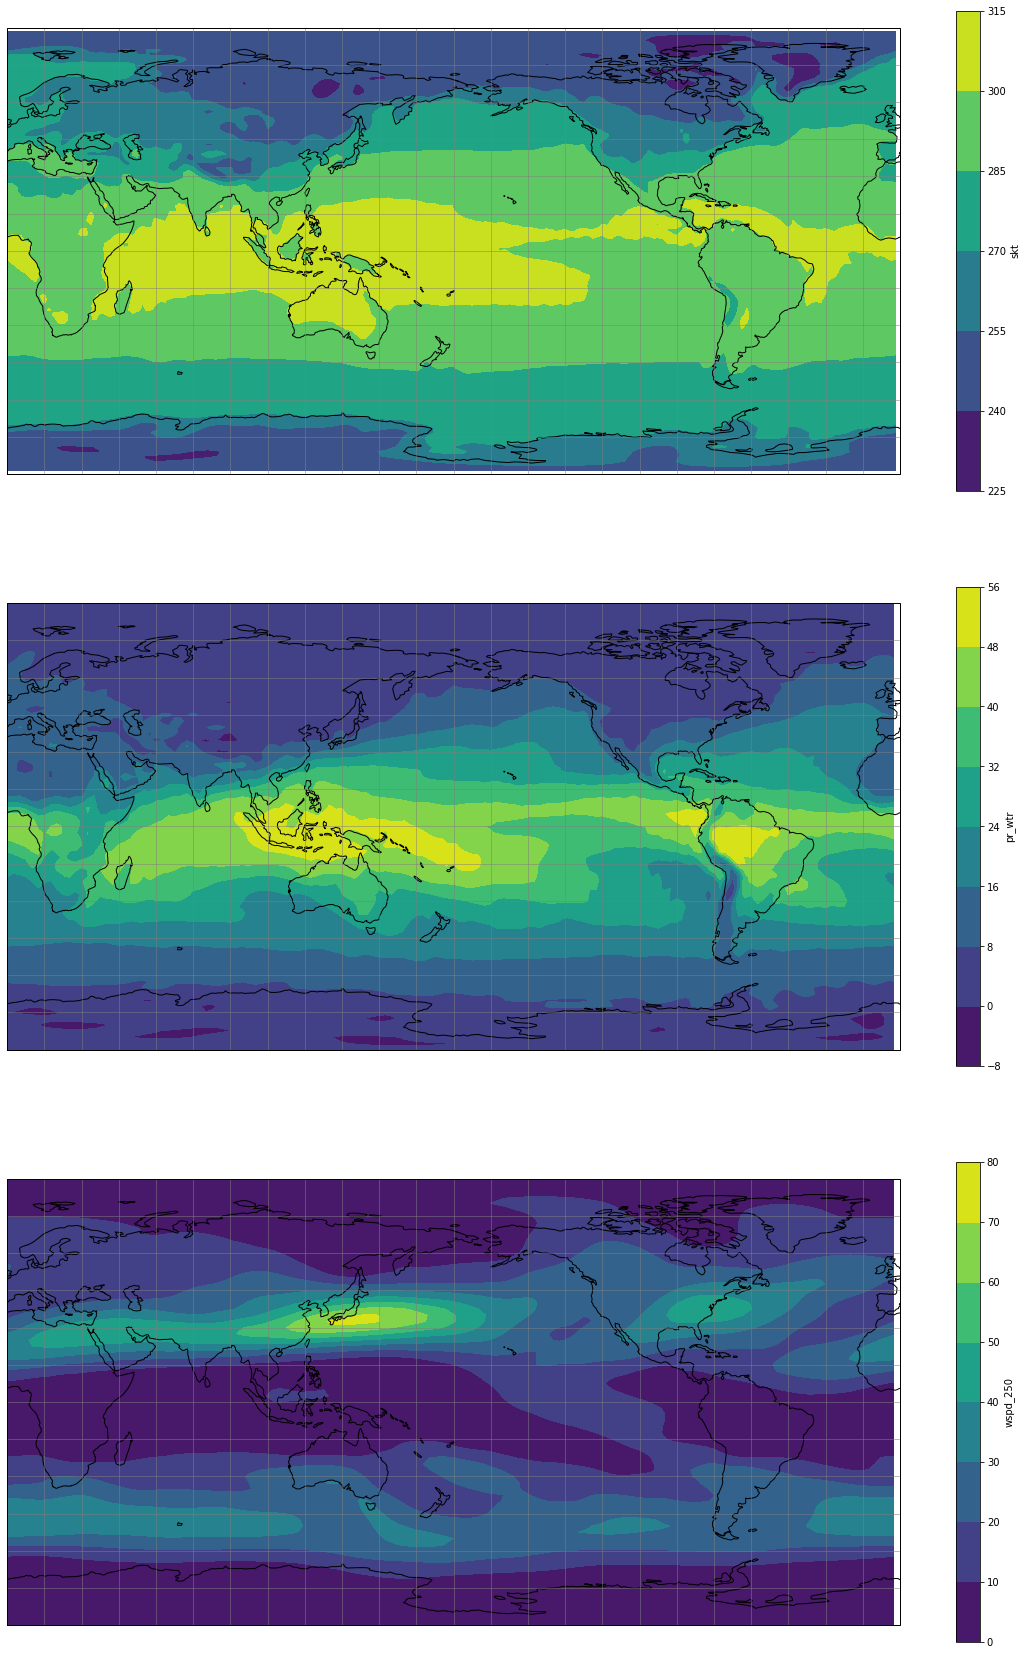

In [0]:
# create figure, axes instances.
fig = plt.figure(figsize=(20, 30))

mkeys = ['skt', 'pr_wtr', 'wspd_250']
n = len(mkeys)

for i in range(n):
    ax = plt.subplot(n, 1, i+1, projection=ccrs.PlateCarree(central_longitude=180))
    data = xprecip_data[mkeys[i]]
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(data['lon'], data['lat'], data, transform=ccrs.PlateCarree())#, levels=np.linspace(0, 70, 8)); # need to specify levels
    ax.set_global(); # for global dataset
    ax.coastlines();
    #im = imshow(wdsp_ref_avg)
    plt.colorbar().set_label(mkeys[i])

    #set up the gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

    #set where the gridlines go
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,15))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,15))

plt.show()

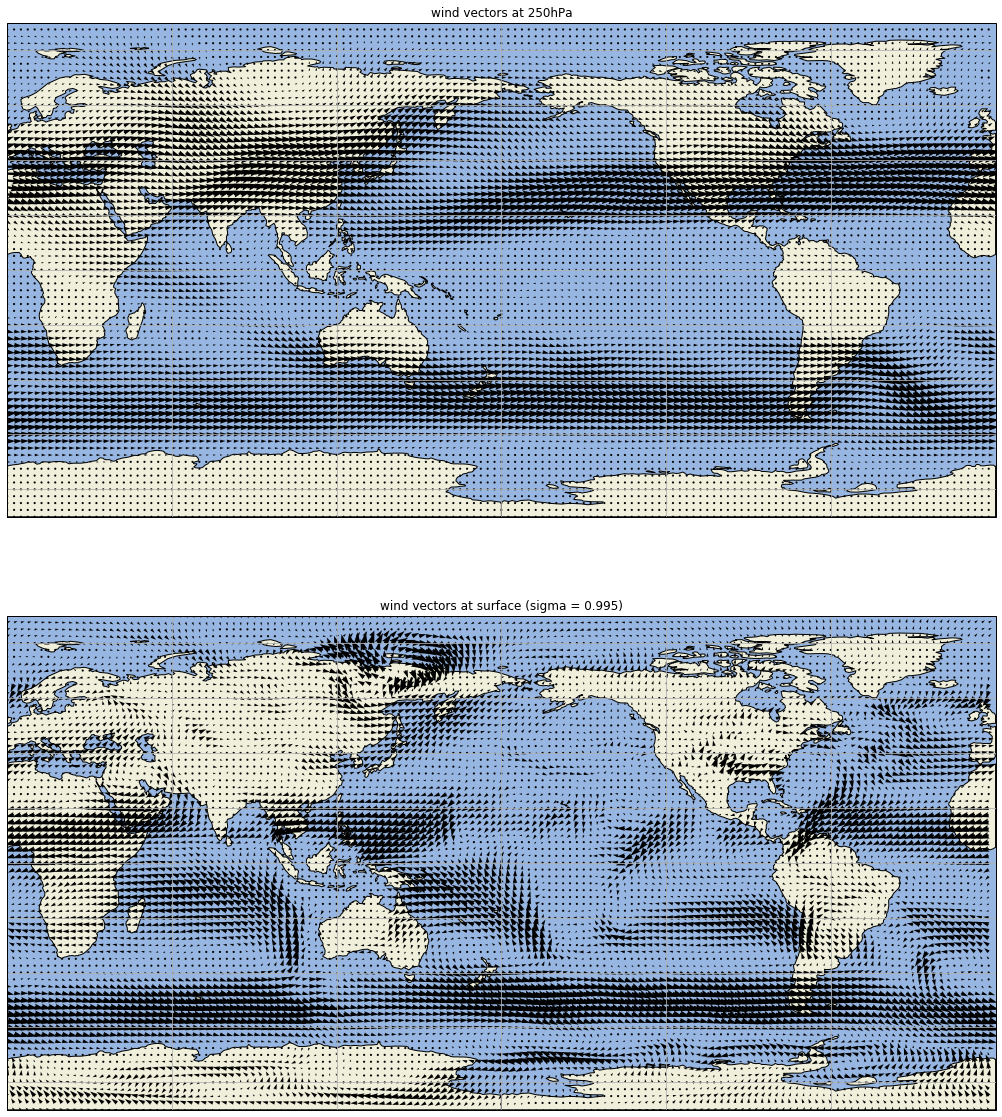

In [0]:
plt.figure(figsize=(20,20))
#wnd250 = anom_data['uwnd_250']

plot_dict = xprecip_data

# 250hPa wind vectors
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cartopy.feature.OCEAN, zorder=0)
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.set_global()
ax1.gridlines()
ax1.set_title('wind vectors at 250hPa')
#x, y, u, v, vector_crs = sample_data()
ax1.quiver(plot_dict['uwnd_250']['lon'], plot_dict['uwnd_250']['lat'], plot_dict['uwnd_250'], plot_dict['vwnd_250'])#, transform=vector_crs)
#ax.barbs(x, y, u, v, transform=vector_crs)
#ax.streamplot(x, y, u, v, transform=vector_crs)

# surface wind vectors
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cartopy.feature.OCEAN, zorder=0)
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.set_global()
ax2.gridlines()
ax2.set_title('wind vectors at surface (sigma = 0.995)')
ax2.quiver(plot_dict['uwnd_sfc']['lon'], plot_dict['uwnd_sfc']['lat'], plot_dict['uwnd_sfc'], plot_dict['vwnd_sfc'])#, transform=vector_crs)

plt.show()

### long term mean maps and vector plots

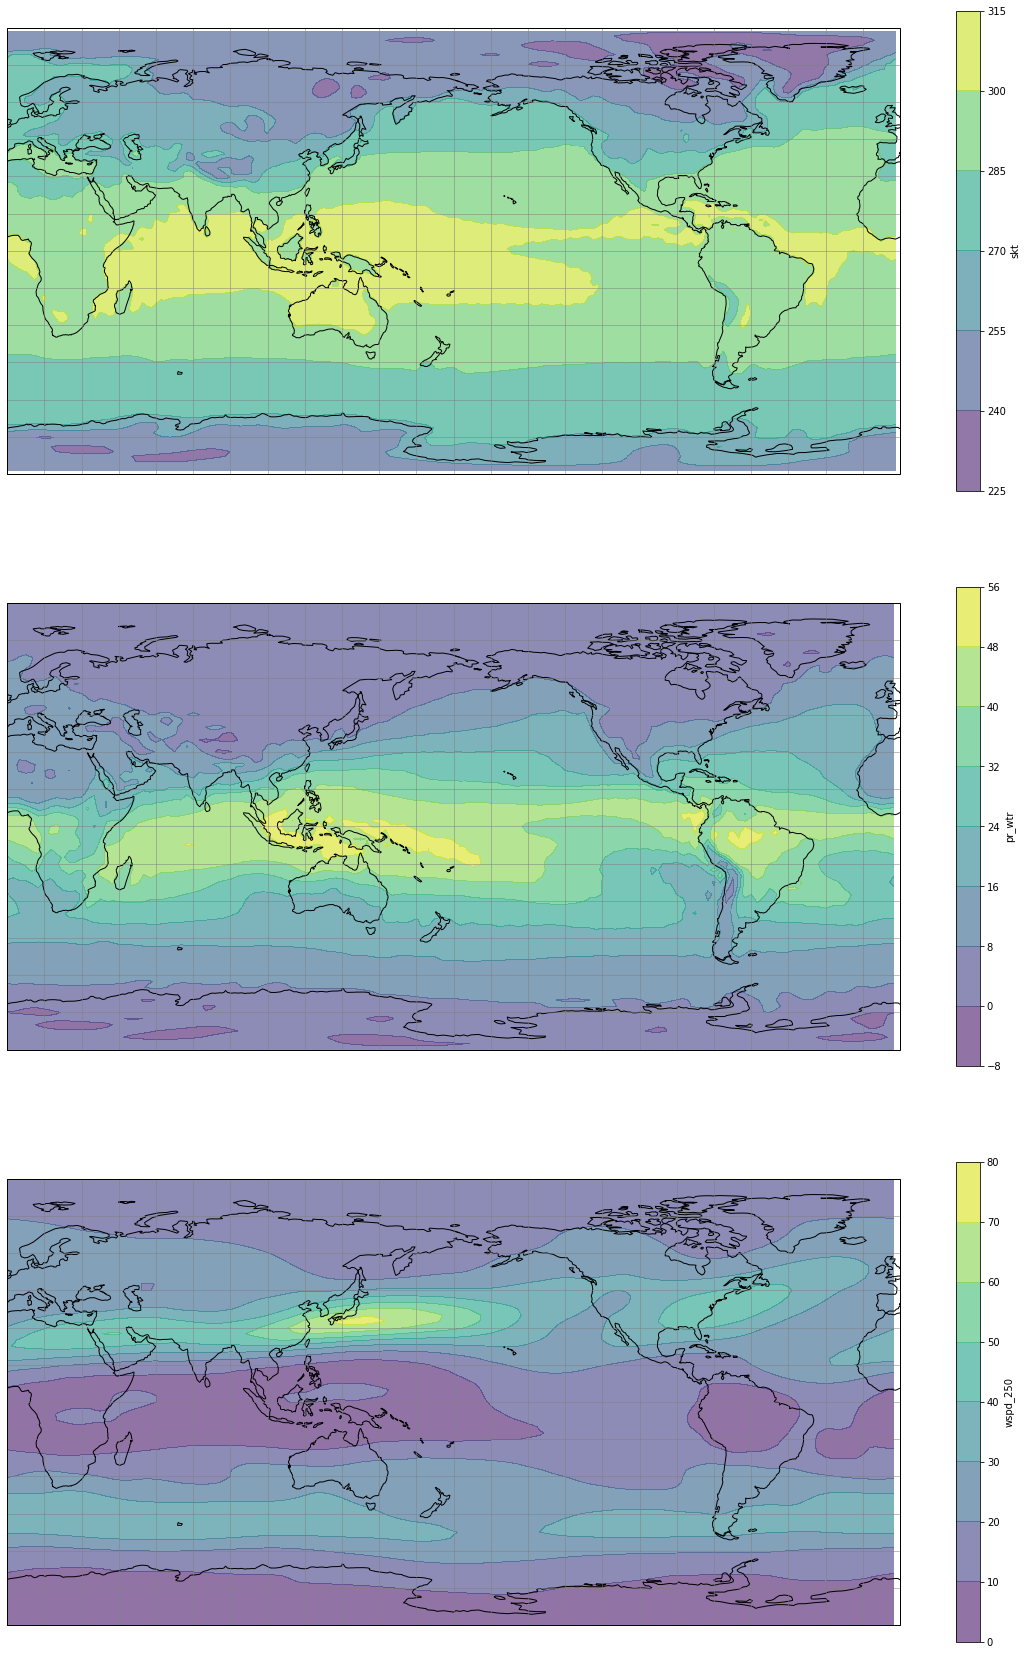

In [0]:
# create figure, axes instances.
fig = plt.figure(figsize=(20, 30))

mkeys = ['skt', 'pr_wtr', 'wspd_250']
n = len(mkeys)

for i in range(n):
    ax = plt.subplot(n, 1, i+1, projection=ccrs.PlateCarree(central_longitude=180))
    ###plotting dict###
    data = ltm_data[mkeys[i]]
    ######
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(data['lon'], data['lat'], data, transform=ccrs.PlateCarree(), alpha = 0.6)#, levels=np.linspace(0, 70, 8)); # need to specify levels
    ax.set_global(); # for global dataset
    ax.coastlines();
    #im = imshow(wdsp_ref_avg)
    plt.colorbar().set_label(mkeys[i])

    #set up the gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

    #set where the gridlines go
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,15))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,15))

plt.show()

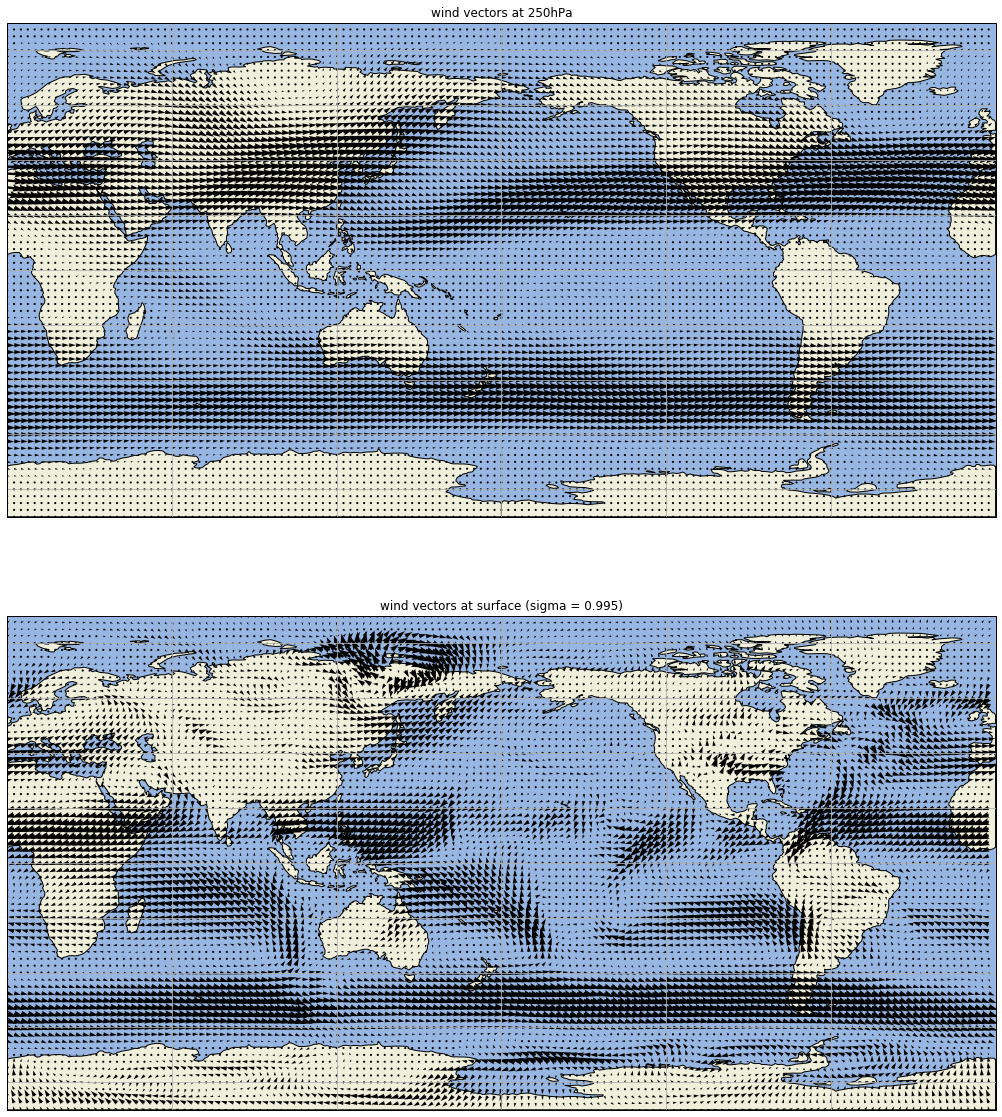

In [0]:
plt.figure(figsize=(20,20))
#wnd250 = anom_data['uwnd_250']

plot_dict = ltm_data

# 250hPa wind vectors
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cartopy.feature.OCEAN, zorder=0)
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.set_global()
ax1.gridlines()
ax1.set_title('wind vectors at 250hPa')
#x, y, u, v, vector_crs = sample_data()
ax1.quiver(plot_dict['uwnd_250']['lon'], plot_dict['uwnd_250']['lat'], plot_dict['uwnd_250'], plot_dict['vwnd_250'])#, transform=vector_crs)
#ax.barbs(x, y, u, v, transform=vector_crs)
#ax.streamplot(x, y, u, v, transform=vector_crs)

# surface wind vectors
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cartopy.feature.OCEAN, zorder=0)
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.set_global()
ax2.gridlines()
ax2.set_title('wind vectors at surface (sigma = 0.995)')
ax2.quiver(plot_dict['uwnd_sfc']['lon'], plot_dict['uwnd_sfc']['lat'], plot_dict['uwnd_sfc'], plot_dict['vwnd_sfc'])#, transform=vector_crs)

plt.show()

### Anomalies maps and vector plots

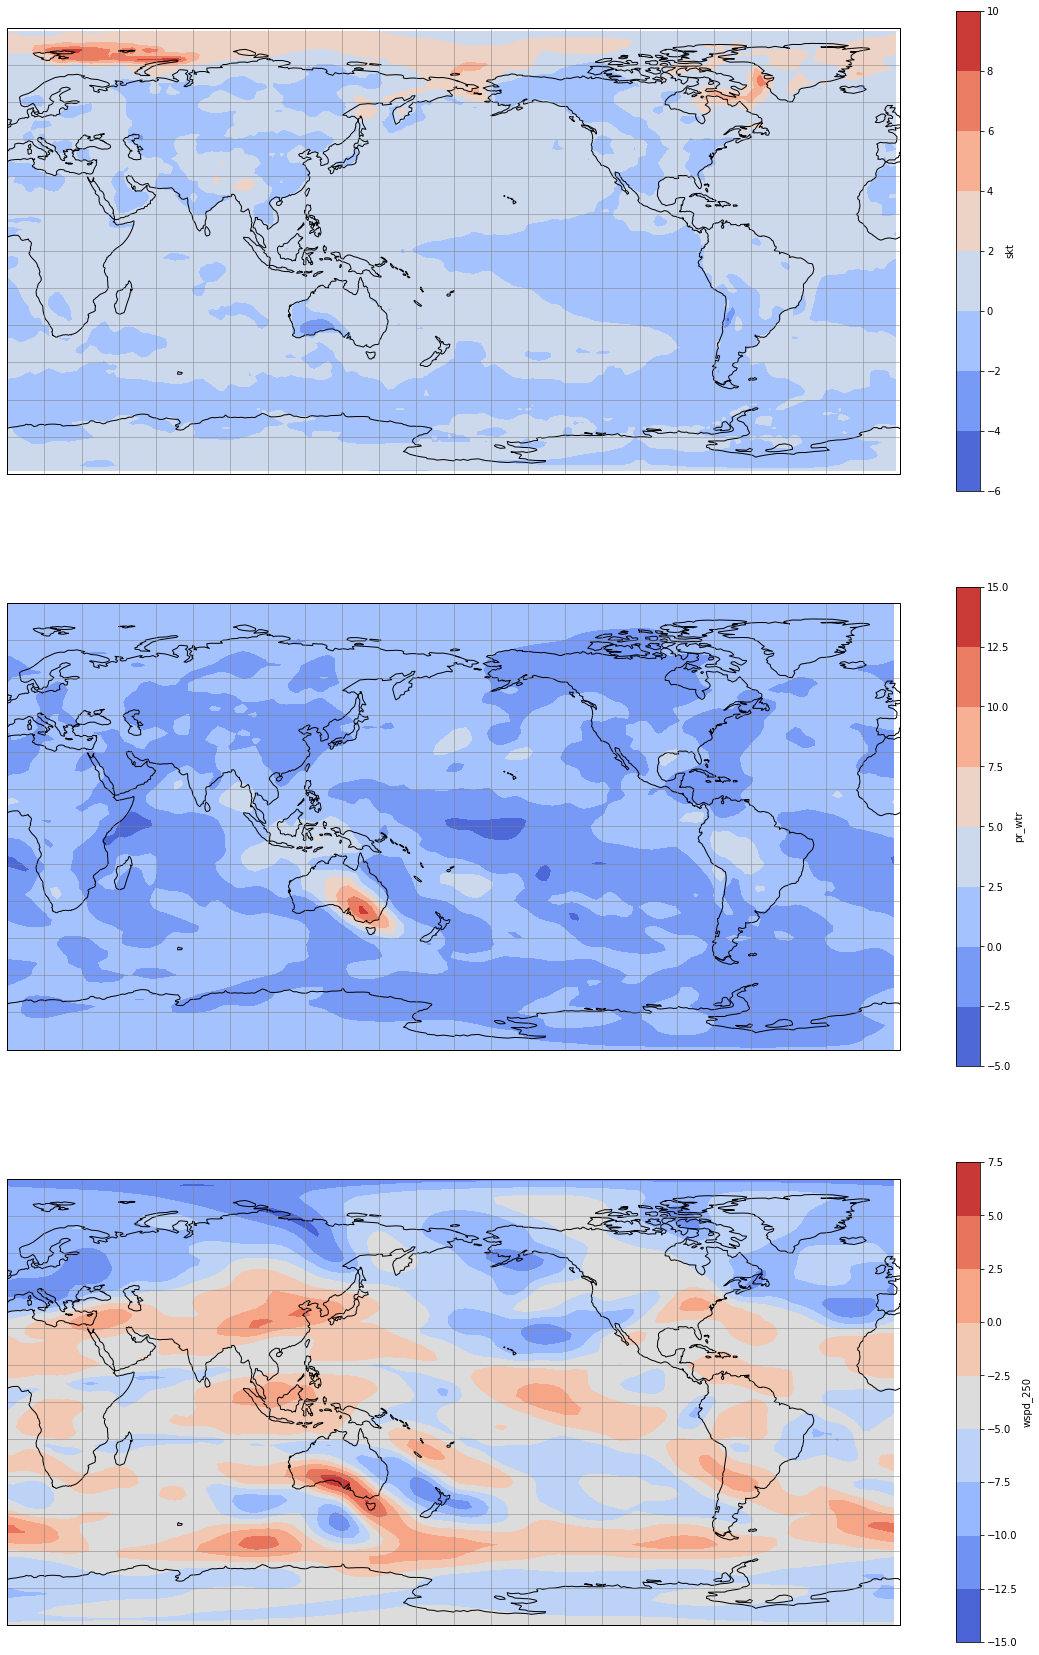

In [0]:
# create figure, axes instances.
fig = plt.figure(figsize=(20, 30))

mkeys = ['skt', 'pr_wtr', 'wspd_250']
n = len(mkeys)

for i in range(n):
    ax = plt.subplot(n, 1, i+1, projection=ccrs.PlateCarree(central_longitude=180))
    data = anom_data[mkeys[i]]
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(data['lon'], data['lat'], data, transform=ccrs.PlateCarree(), cmap='coolwarm')#, levels=np.linspace(0, 70, 8)); # need to specify levels
    ax.set_global(); # for global dataset
    ax.coastlines();
    #im = imshow(wdsp_ref_avg)
    plt.colorbar().set_label(mkeys[i])

    #set up the gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')

    #set where the gridlines go
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,15))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,15))

plt.show()



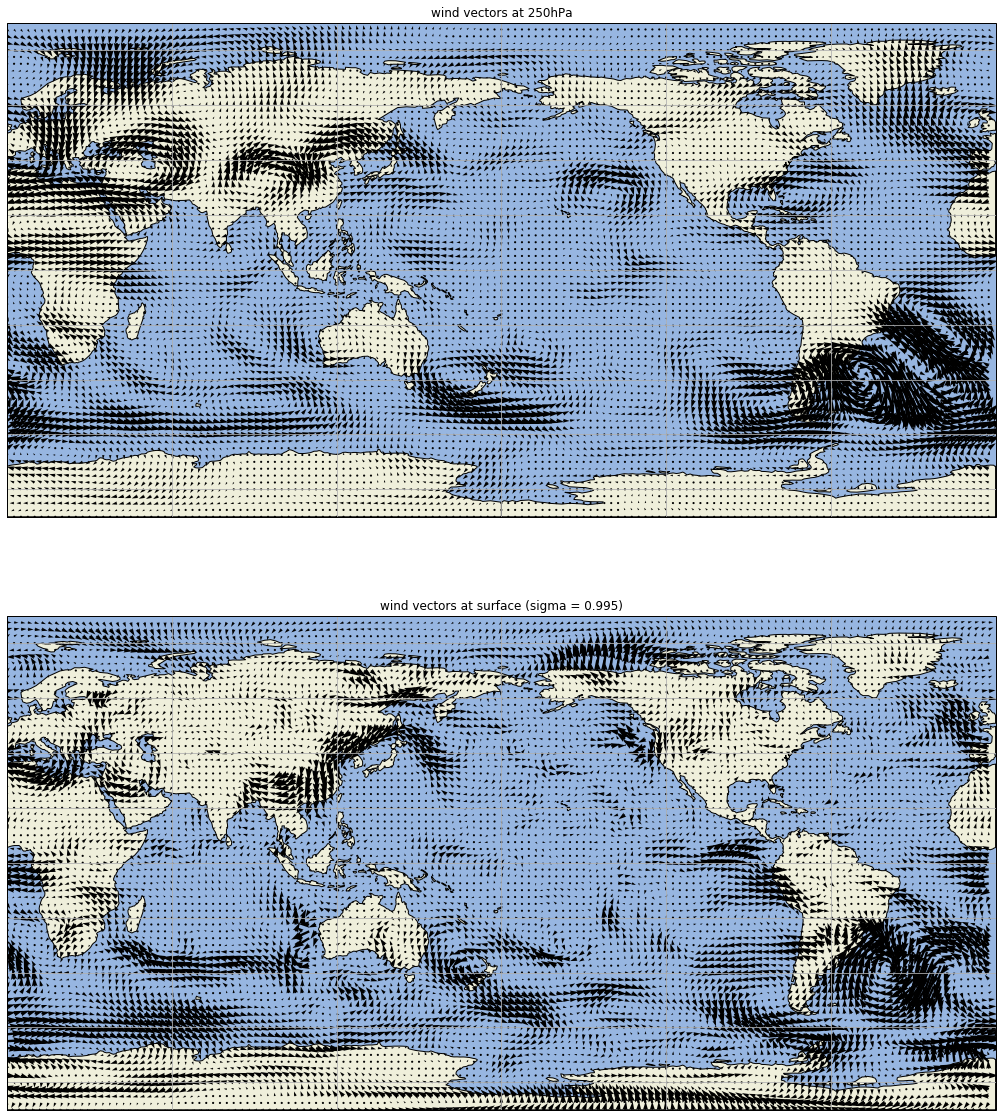

In [0]:
plt.figure(figsize=(20,20))
#wnd250 = anom_data['uwnd_250']

plot_dict = anom_data

# 250hPa wind vectors
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cartopy.feature.OCEAN, zorder=0)
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.set_global()
ax1.gridlines()
ax1.set_title('wind vectors at 250hPa')
#x, y, u, v, vector_crs = sample_data()
ax1.quiver(plot_dict['uwnd_250']['lon'], plot_dict['uwnd_250']['lat'], plot_dict['uwnd_250'], plot_dict['vwnd_250'])#, transform=vector_crs)
#ax.barbs(x, y, u, v, transform=vector_crs)
#ax.streamplot(x, y, u, v, transform=vector_crs)

# surface wind vectors
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cartopy.feature.OCEAN, zorder=0)
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.set_global()
ax2.gridlines()
ax2.set_title('wind vectors at surface (sigma = 0.995)')
ax2.quiver(plot_dict['uwnd_sfc']['lon'], plot_dict['uwnd_sfc']['lat'], plot_dict['uwnd_sfc'], plot_dict['vwnd_sfc'])#, transform=vector_crs)

plt.show()